In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import statistics as stats
from collections import Counter
from scipy.stats import fisher_exact, yeojohnson, wilcoxon
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, pearsonr, spearmanr
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, PoissonRegressor
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
from matplotlib import rc

In [3]:
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})

In [4]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)

# Importing mocha for mosaic chromosomal abnormalities 

In [5]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/long.mocha.filtered.csv .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/long.mocha.filtered.csv...
/ [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation completed over 1 objects/1.2 MiB.                                      


In [6]:
mocha_df = pd.read_csv("long.mocha.filtered.csv", sep = '\t')

## Standardize the p and q arm notation

In [7]:
mocha_df['q_arm_bool'] = False
mocha_df.loc[(mocha_df['q_arm'] == 'T'),'q_arm_bool'] = True
mocha_df.loc[(mocha_df['q_arm'] == 'Y'),'q_arm_bool'] = True
mocha_df.loc[(mocha_df['q_arm'] == 'TRUE'),'q_arm_bool'] = True
mocha_df['p_arm_bool'] = False
mocha_df.loc[(mocha_df['p_arm'] == 'T'),'p_arm_bool'] = True
mocha_df.loc[(mocha_df['p_arm'] == 'Y'),'p_arm_bool'] = True
mocha_df.loc[(mocha_df['p_arm'] == 'TRUE'),'p_arm_bool'] = True
mocha_df['botharms_bool'] = False
mocha_df.loc[(mocha_df['p_arm_bool']==True) & (mocha_df['q_arm_bool']==True), 'botharms_bool'] = True
mocha_df['arm_short'] = ''
mocha_df.loc[((mocha_df['p_arm_bool']) == True & (mocha_df['q_arm_bool']==False)),'arm_short'] = 'p'
mocha_df.loc[((mocha_df['p_arm_bool']) == False & (mocha_df['q_arm_bool']==True)),'arm_short'] = 'q'
mocha_df.loc[(mocha_df['botharms_bool'] == True),'arm_short'] = ''

## Standardize the mCA type notation 

In [8]:
mocha_df['type_short'] = "U"
mocha_df.loc[mocha_df['type'] == 'Gain', 'type_short'] = "+"
mocha_df.loc[mocha_df['type'] == 'Loss', 'type_short'] = "-"
mocha_df.loc[mocha_df['type'] == 'CN-LOH', 'type_short'] = "="

### Combine mCA information for a row 

In [9]:
mocha_df['mca'] = mocha_df['type'] + " in " + mocha_df['chrom']
mocha_df['chrom_short'] = mocha_df['chrom'].str.replace("chr","")
mocha_df['mca_short'] = mocha_df['chrom_short'] + mocha_df['type_short']
mocha_df['mca_short_arm'] = mocha_df['chrom_short'] + mocha_df['arm_short'] + mocha_df['type_short']

In [10]:
mocha_df_nochrx = mocha_df[mocha_df['chrom'] != 'chrX']
mocha_df_nochrx['chrom_short'] = pd.to_numeric(mocha_df_nochrx['chrom_short'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
mocha_df_nochrx['NWD_ID'] = mocha_df_nochrx['sample_id']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Importing data from Michael Raddatz - now using more complete dataset of ~75k

In [12]:
cov_df = pd.read_csv("topmed_tcell_cov.txt", sep = '\t')
sex_dict = pd.Series(cov_df.sex.values,index=cov_df['sample']).to_dict()
age_dict = pd.Series(cov_df.AgeAtBloodDraw.values,index=cov_df['sample']).to_dict()

In [13]:
#Read in data, subset to C>T and T>C mutations, and obtain passenger mutation count
topmed_df = pd.read_parquet('singletons_spark_2021_05_25.parquet')
topmed_ct_df = topmed_df[((topmed_df.REF == "C") & (topmed_df.ALT == "T")) | ((topmed_df.REF == "T") & (topmed_df.ALT == "C"))]

# Removing any passengers on the mCA chromosome 

In [14]:
merged_df = pd.merge(mocha_df_nochrx, topmed_ct_df, on=['NWD_ID'], how='inner')

In [15]:
merged_df = merged_df.loc[merged_df['chrom_short'] != merged_df['CHROM']]
merged_df_plus1 = merged_df.loc[merged_df['chrom_short'] != merged_df['CHROM']+1]

In [16]:
cf_dict = pd.Series(merged_df.cf.values,index=merged_df['NWD_ID']).to_dict()

In [17]:
merged_df_passengers = pd.DataFrame(merged_df['NWD_ID'].value_counts())
merged_df_passengers = merged_df_passengers.reset_index(level=0)
merged_df_passengers.columns = ['NWD_ID', 'sum']

In [18]:
merged_df_passengers_plus1 = pd.DataFrame(merged_df_plus1['NWD_ID'].value_counts())
merged_df_passengers_plus1 = merged_df_passengers_plus1.reset_index(level=0)
merged_df_passengers_plus1.columns = ['NWD_ID', 'sum']

In [19]:
merged_df_passengers['age'] = merged_df_passengers['NWD_ID'].map(age_dict)
merged_df_passengers['sex'] = merged_df_passengers['NWD_ID'].map(sex_dict)
merged_df_passengers['cf'] = merged_df_passengers['NWD_ID'].map(cf_dict)
merged_df_passengers = merged_df_passengers.rename(columns={"sum": "total_pass_mut", "NWD_ID": "sample.id"})

In [20]:
merged_df_passengers_plus1['age'] = merged_df_passengers_plus1['NWD_ID'].map(age_dict)
merged_df_passengers_plus1['sex'] = merged_df_passengers_plus1['NWD_ID'].map(sex_dict)
merged_df_passengers_plus1['cf'] = merged_df_passengers_plus1['NWD_ID'].map(cf_dict)
merged_df_passengers_plus1 = merged_df_passengers_plus1.rename(columns={"sum": "total_pass_mut", "NWD_ID": "sample.id"})

Min: 2
Max: 4409
Median: 71.0


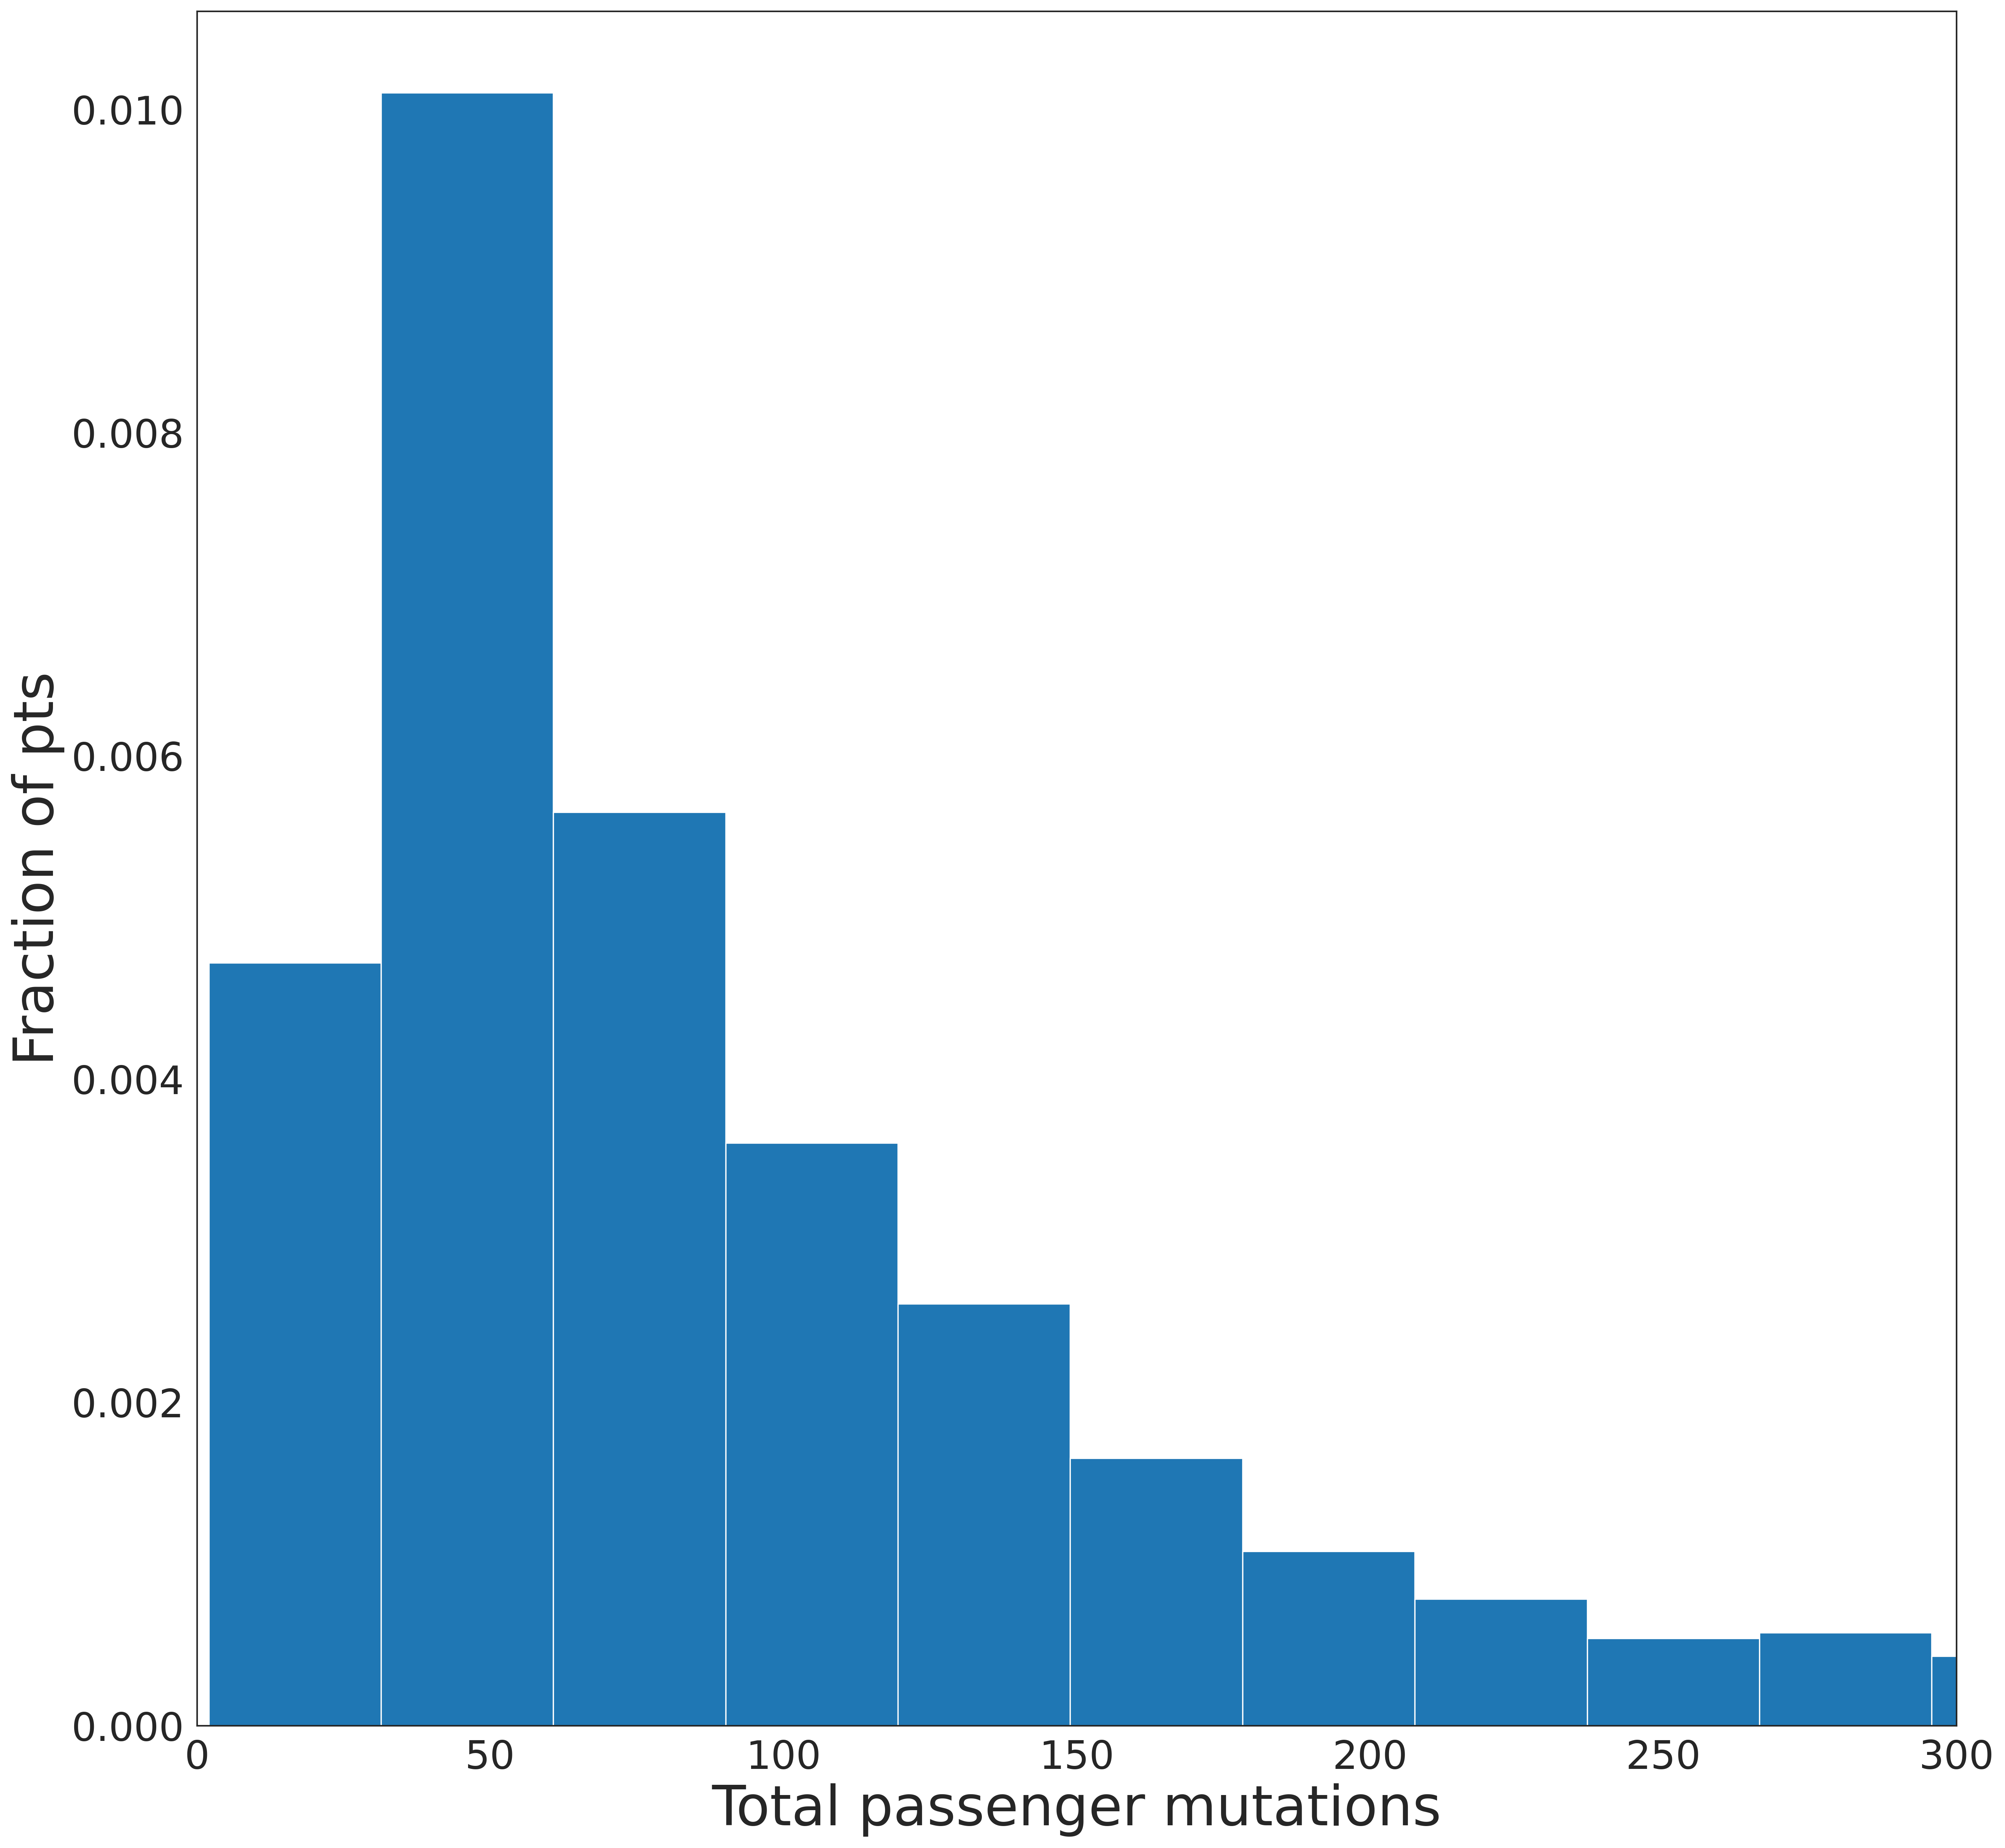

In [21]:
plt.figure(dpi=300, figsize=(20,20))
plt.hist(merged_df_passengers['total_pass_mut'], density = True, bins = 150)
plt.ylabel('Fraction of pts', fontsize=35)
plt.xlabel('Total passenger mutations', fontsize=35)
# plt.title("Histogram of total passenger mutations")
plt.xlim(0,300)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
print("Min: " + str(min(merged_df_passengers['total_pass_mut'])))
print("Max: " + str(max(merged_df_passengers['total_pass_mut'])))
print("Median: " + str(stats.median(merged_df_passengers['total_pass_mut'])))

In [22]:
merged_df_passengers['sex_dummy'] = 0
merged_df_passengers.loc[merged_df_passengers['sex'] == 'M', 'sex_dummy'] = 1

In [23]:
merged_df_passengers_plus1['sex_dummy'] = 0
merged_df_passengers_plus1.loc[merged_df_passengers_plus1['sex'] == 'M', 'sex_dummy'] = 1

In [24]:
merged_df_passengers = merged_df_passengers.dropna()
merged_df_passengers_plus1 = merged_df_passengers_plus1.dropna()

In [25]:
reg = PoissonRegressor().fit(merged_df_passengers[['age', 'sex_dummy', 'cf']].to_numpy(), merged_df_passengers['total_pass_mut'].to_numpy())
y_pred = reg.predict(merged_df_passengers[['age', 'sex_dummy', 'cf']].to_numpy())
residuals = merged_df_passengers['total_pass_mut'].to_numpy()- np.array(y_pred)

In [26]:
reg_plus1 = PoissonRegressor().fit(merged_df_passengers_plus1[['age', 'sex_dummy', 'cf']].to_numpy(), merged_df_passengers_plus1['total_pass_mut'].to_numpy())
y_pred_plus1 = reg_plus1.predict(merged_df_passengers_plus1[['age', 'sex_dummy', 'cf']].to_numpy())
residuals_plus1 = merged_df_passengers_plus1['total_pass_mut'].to_numpy()- np.array(y_pred_plus1)

In [27]:
residuals_t, lmbda = yeojohnson(residuals)
residuals_t_norm = normalize([residuals_t])

In [28]:
residuals_t_plus1, lmbda_plus1 = yeojohnson(residuals_plus1)
residuals_t_norm_plus1 = normalize([residuals_t_plus1])

In [29]:
merged_df_passengers['pacer_covadj_int_withoutmcachr'] = residuals_t_norm[0]*20
merged_df_passengers_plus1['pacer_covadj_int_withoutmcachr'] = residuals_t_norm_plus1[0]*20

In [30]:
pacer_withmCAchr_df = pd.read_csv('pacer_covadj_forGWAS_nochip_yp_aug12.tsv', sep='\t')

In [31]:
pacer_df = pd.merge(merged_df_passengers, pacer_withmCAchr_df, on=['sample.id'], how='inner')
pacer_df_plus1 = pd.merge(merged_df_passengers_plus1, pacer_withmCAchr_df, on=['sample.id'], how='inner')

In [32]:
pacer_df_filt = pacer_df.loc[pacer_df['pacer_covadj_int_withoutmcachr']>-1]
pacer_df_filt_plus1 = pacer_df_plus1.loc[pacer_df_plus1['pacer_covadj_int_withoutmcachr']>-1]

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


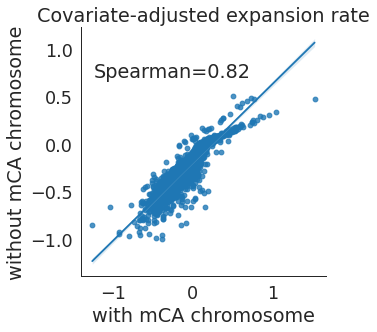

In [33]:
def annotate(data, **kws):
    r, p = spearmanr(data['pacer_covadj_int_norm'], data['pacer_covadj_int_withoutmcachr'])
    ax = plt.gca()
    ax.text(.05, .8, 'Spearman={:.2f}'.format(r**2),
            transform=ax.transAxes)

g = sns.lmplot('pacer_covadj_int_norm','pacer_covadj_int_withoutmcachr', 
               data=pacer_df_filt)
plt.xlabel('with mCA chromosome')
plt.ylabel('without mCA chromosome')
plt.title('Covariate-adjusted expansion rate')
g.map_dataframe(annotate)

plt.show()


In [34]:
X = pacer_df_filt[['pacer_covadj_int_norm']]
y = pacer_df_filt['pacer_covadj_int_withoutmcachr']

X = sm.add_constant(X)

# Fit the linear regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the results summary
print(model.summary())

                                  OLS Regression Results                                  
Dep. Variable:     pacer_covadj_int_withoutmcachr   R-squared:                       0.802
Model:                                        OLS   Adj. R-squared:                  0.802
Method:                             Least Squares   F-statistic:                     7490.
Date:                            Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                                    16:22:07   Log-Likelihood:                 1583.9
No. Observations:                            1849   AIC:                            -3164.
Df Residuals:                                1847   BIC:                            -3153.
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


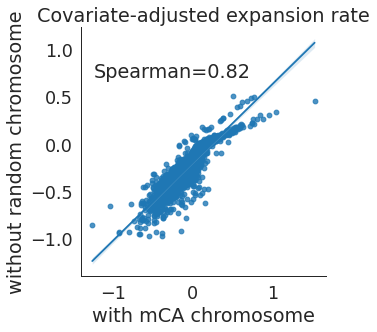

In [35]:
g = sns.lmplot('pacer_covadj_int_norm','pacer_covadj_int_withoutmcachr', 
               data=pacer_df_filt_plus1)
plt.xlabel('with mCA chromosome')
plt.ylabel('without random chromosome')
plt.title('Covariate-adjusted expansion rate')
g.map_dataframe(annotate)

plt.show()

In [36]:
X = pacer_df_filt_plus1[['pacer_covadj_int_norm']]
y = pacer_df_filt_plus1['pacer_covadj_int_withoutmcachr']

X = sm.add_constant(X)

# Fit the linear regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the results summary
print(model.summary())

                                  OLS Regression Results                                  
Dep. Variable:     pacer_covadj_int_withoutmcachr   R-squared:                       0.800
Model:                                        OLS   Adj. R-squared:                  0.800
Method:                             Least Squares   F-statistic:                     7393.
Date:                            Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                                    16:22:08   Log-Likelihood:                 1564.8
No. Observations:                            1849   AIC:                            -3126.
Df Residuals:                                1847   BIC:                            -3115.
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
